## Novel Molecule Generation using Bidirectional-Recurrent Neural Networks with Attention Applied to Simplified Molecular Input Line Entry Sysem (SMILES)

## Generate Molecules

author: anthony j. vasquez
email: vanthony715@gmail.com / avasque1@jh.edu

In [1]:
import time
from datetime import datetime
t0 = time.time()

import sys
sys.path.append('./data/')

import gc
gc.collect()

import os
##had a hard time with this setting on windows os using spyder and jypyter
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import warnings
warnings.filterwarnings("ignore")

import platform
print("Operating System: ", platform.system())
print("Machine Type:: ", platform.machine())

import multiprocessing as mp
max_processors = mp.cpu_count()
print('Processor Count: ', max_processors, '\n')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from net import *
from utils import *
from custom_dataset import *

if torch.cuda.is_available():
    torch.cuda.empty_cache() #empty cache
    print('CUDA Version')
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')
    print('\n')

##hardware params
# DEVICE = torch.device('cpu') #DEBUG
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: \n', DEVICE)

Operating System:  Linux
Machine Type::  x86_64
Processor Count:  24 

CUDA Version
CUDNN Version: 90100
Number of CUDA Devices: 2
Active CUDA Device: 0
Available devices: 2, Name: NVIDIA RTX A4000
Current CUDA device: 0


Using Device: 
 cuda


#### Hyperparameters

In [2]:
##OS
LINUX = True #windows isn't nice with parallel processes
MULTI_GPU = True #trains using multiple gpus
N_PROCESSORS = max_processors - 2 #leave 2 processors free 

##data
HOLDOUT_PERC = 0.85 #percentage to holdout 
TRAIN_BS = 512 #train batch size
PREFETCH_FACTOR = 4 #effectively reduces gpu load time 
NUM_WORKERS = 8 #number of jobs for generation tasks

##inference
N_SAMPLES = 1000 #num samples to generate
MAX_LENGTH = 10 #len of samples to generate

##netork params
##TODO write a yaml file with the best parameters and load them here
OPTIMIZER = 'rmsprop' ##or adam
LRG = 0.004086800025392213 #learning rate generator
LRD = 0.013448070902660135 #learning rate discriminator
LRS_SZ = 5 #learning rate scheduler step size
LRS_GAMMA = 0.99 #learning rate scheduler gamma
BETAS = (0.5, 0.999) #momentum moving average
DROPOUT_PROB = 0.5 #dropout
WEIGHT_DECAY = 1e-5 #L2 Regularization
RUN_EXTRA_TIMES = 3 #iterate over validator extra times for every one time that the generator ates
EMBEDDING_DIM = 32 #how large of a vector to represent input data
HIDDEN_DIM = 128 #learned embeddings
N_LAYERS = 2 #num gru layers
BIDIRECTIONAL = True #makes gru layer bidirectional
N_HEADS = 4 #number of heads for attention, scaled dot-product for head's respective section of sequence
CLIP_VALUE = 0.008101987508250374 ##WGAN discriminator clip value for training stabalization

##visualization params
SIGMA = 2 #loss smoothing for lineplot
PRINT_LOSS_EVERY = 2 #how many epochs to output loss

##logging
RESULTS_PATH = './results/'
BEST_GEN_NET_PATH = RESULTS_PATH + 'epoch_25_exper_at_datetime_21-08-2024_09-06-54/gnet.pt'

In [3]:
WRITEPATH = RESULTS_PATH + 'infererence_tune/'
make_dir(WRITEPATH)

Created Folder at:  ./results/infererence_tune/


#### Open SMILES Data

In [4]:
%%time

### Import the data
data_file = pd.read_csv('./data/Zinc_all_smiles_data.txt', header = None)
data_file.columns = ['smiles']
smilesList = data_file['smiles'].tolist()

# ##split dset
# train_smiles, holdout_smiles, _, _ = train_test_split(smilesList, smilesList, test_size=HOLDOUT_PERC, random_state=42)
# print('Len all smiles: ', len(smilesList))
# print('Len train smiles: ', len(train_smiles))
# print('Len holdout smiles: ', len(holdout_smiles))

print('\n')



CPU times: user 138 ms, sys: 19.7 ms, total: 158 ms
Wall time: 163 ms


In [5]:
%%time

# Example usage:
vocab = build_vocabulary(smilesList)
max_length = max(len(tokenize_smiles(smiles)) for smiles in smilesList)

print('Data Summary: ')
print('smilesList Len: ', len(smilesList))
print('vocab len: ', len(vocab))
print('smiles max_length: ', max_length)
print('\n')

Data Summary: 
smilesList Len:  249456
vocab len:  254593
smiles max_length:  27


CPU times: user 669 ms, sys: 1.71 ms, total: 670 ms
Wall time: 670 ms


Open Trained Generator Network

In [6]:
%%time

##init Generator networks
n_gen = Generator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=N_LAYERS, max_length=max_length, 
                  num_heads=N_HEADS, dropout_prob=DROPOUT_PROB, bidirectional=BIDIRECTIONAL).to(DEVICE)

print('\nTotal generator param cnt: ', count_parameters(n_gen))
print('Trainable generator param cnt: ', count_trainable_parameters(n_gen))

##check if was run in parallel and generate new state dict
state_dict = torch.load(BEST_GEN_NET_PATH, map_location=torch.device(DEVICE))
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('module.'):
        new_key = key[len('module.'):]
    else:
        new_key = key
    new_state_dict[new_key] = value

n_gen.load_state_dict(new_state_dict)

print('\n')


Total generator param cnt:  74261698
Trainable generator param cnt:  74261698


CPU times: user 1.26 s, sys: 701 ms, total: 1.96 s
Wall time: 2.86 s


In [7]:
n_gen

Generator(
  (embedding): Embedding(254594, 32)
  (gru): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=254594, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Generate Molecules Using Trained GAN Generator 

In [8]:
%%capture

t1 = time.time()

##max vector lengths to try
max_lengths = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

##not in tune loop
##generate the known smiles (canonical) - used for novelty check
known_can_smiles = process_smiles_in_parallel(smiles_list=smilesList, function_object=canonicalize_smiles, n_processors=N_PROCESSORS)
print('\nLen known canonical smiles: ', len(known_can_smiles))

##iterate over max lengths
##doing these two alone because of how long the warning strings are for check_smiles_validity
val_smiles_list, inval_smiles_list = [], [] 
for max_len in max_lengths:

    ##generate smiles
    gen_smiles = generate_smiles(n_gen, vocab, num_samples=N_SAMPLES, max_length=max_len, device=DEVICE)
    
    ##check validity
    valid_smiles, invalid_smiles = check_smiles_validity(gen_smiles)
    val_smiles_list.append(valid_smiles)
    inval_smiles_list.append(invalid_smiles)
    
print('\n')

In [9]:
print('Gen Smiles Took: ', np.round(time.time() - t1, 3), 's')

Gen Smiles Took:  237.401 s


In [10]:
%%time

##performance dict
perf = {'max_len': [], 
        'val_cnt': [], 
        'inval_cnt': [], 
        'novel_cnt': [], 
        'max_sol': [], 
        'mean_sol': [], 
        'std_sol':[],
        'max_qed': [], 
        'mean_qed': [], 
        'std_qed': [],
        'max_synth': [], 
        'mean_synth': [], 
        'std_synth': []}

##iterate over max lengths
for i, max_len in tqdm(enumerate(max_lengths)):
    
    ##check validity
    valid_smiles, invalid_smiles = val_smiles_list[i], inval_smiles_list[i]
    
    ##check novelty valid generated smiles
    ##iterate over unique valid smiles generations, then compare with known smiles
    novel_smiles = [] 
    # for smiles in list(set(valid_smiles)):
    #     if len(smiles):
    can_smiles = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), 
                                            function_object=canonicalize_smiles, 
                                            n_processors=N_PROCESSORS)
    for can_smile in can_smiles:
        if is_novel(can_smiles, known_can_smiles):
            novel_smiles.append(can_smiles)
    
    ##check solubility
    ##iterate over unique valid smiles generations, then compare with known smiles
    sols = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), 
                                      function_object=estimate_solubility, 
                                      n_processors=N_PROCESSORS)
    
    ##check drug likeness
    qeds = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), 
                                      function_object=calculate_qed, 
                                      n_processors=N_PROCESSORS)
    
    # ##check synthesizeability
    synth = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), 
                                       function_object=estimate_synthesizeability, 
                                       n_processors=N_PROCESSORS)

    ##log findings
    perf['max_len'].append(max_len)
    perf['val_cnt'].append(len(valid_smiles))
    perf['inval_cnt'].append(len(invalid_smiles))
    perf['novel_cnt'].append(len(novel_smiles))
    perf['max_sol'].append(np.max(sols))
    perf['mean_sol'].append(np.mean(sols))
    perf['std_sol'].append(np.std(sols))
    perf['max_qed'].append(np.max(qeds))
    perf['mean_qed'].append(np.mean(qeds))
    perf['std_qed'].append(np.std(qeds))
    perf['max_synth'].append(np.max(synth))
    perf['mean_synth'].append(np.mean(synth))
    perf['std_synth'].append(np.std(synth))
    
print('\n')

12it [00:28,  2.33s/it]



CPU times: user 1.6 s, sys: 23.5 s, total: 25.1 s
Wall time: 28 s


In [11]:
##write findings to file
df = pd.DataFrame(perf)
df = df.sort_values(by='novel_cnt', ascending=False)
df.to_csv(WRITEPATH + '/tuned_inference_results_25_epoch.csv', index=False)
df

,max_len,val_cnt,inval_cnt,novel_cnt,max_sol,mean_sol,std_sol,max_qed,mean_qed,std_qed,max_synth,mean_synth,std_synth
11,14,186,814,22,-0.073,-0.491864,0.239140,0.112,0.025318,0.020914,249.168,143.211636,49.005780
9,12,182,818,20,0.305,-0.466700,0.204724,0.040,0.022700,0.009193,186.177,135.458100,25.179219
10,13,153,847,17,-0.189,-0.509353,0.149365,0.034,0.021118,0.008983,231.371,148.184471,33.608022
7,10,318,682,15,0.256,-0.343667,0.202439,0.050,0.021267,0.010382,178.381,113.543867,27.103893
6,9,353,647,14,0.231,-0.338286,0.203710,0.059,0.025000,0.012801,122.877,102.832286,16.448640
8,11,243,757,14,0.280,-0.359071,0.248423,0.044,0.025357,0.010188,196.218,117.982357,35.209098
4,7,343,657,12,0.181,-0.188333,0.163317,0.087,0.025000,0.020220,142.267,91.113917,23.154095
5,8,333,667,11,0.206,-0.235818,0.178596,0.071,0.025727,0.016209,162.589,98.255727,24.229399
3,6,151,849,10,0.156,-0.178000,0.140694,0.116,0.031400,0.029014,121.944,74.510300,18.819300
2,5,175,825,4,-0.042,-0.134250,0.092080,0.034,0.025500,0.008500,101.622,70.260750,18.474465


In [12]:
best_idx = df.index[0]
valid_smiles, invalid_smiles = val_smiles_list[best_idx], inval_smiles_list[best_idx]

In [13]:
%%time

print("\n\n==================================================Stats==================================================")
basic_stats = summary_stats(valid_smiles, invalid_smiles)

print("\n\n===============================================Valid SMILES===============================================")
for i, smiles in enumerate(list(set(valid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print("\n\n===============================================Inalid SMILES===============================================")
for i, smiles in enumerate(list(set(invalid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print('\n')



==================================================Stats==================================================
total generated cnt:  1000
valid cnt:  186
invalid Count:  814
unique valid cnt:  22
unique invalid cnt:  85
percent unique valid:  2.2
percent unique invalid:  8.5
ratio unique_valid/unique_invalid:  0.26


===============================================Valid SMILES===============================================

0.  CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1CC(C)OCCN1CCN(C(=O)C2(c3ccccc3F)CC2)CC1

1.  COC(=O)c1cc(CNC(=O)c

### Visualize GAN Generated Molecules for Best Tuning

CPU times: user 634 ms, sys: 9.35 ms, total: 643 ms
Wall time: 643 ms


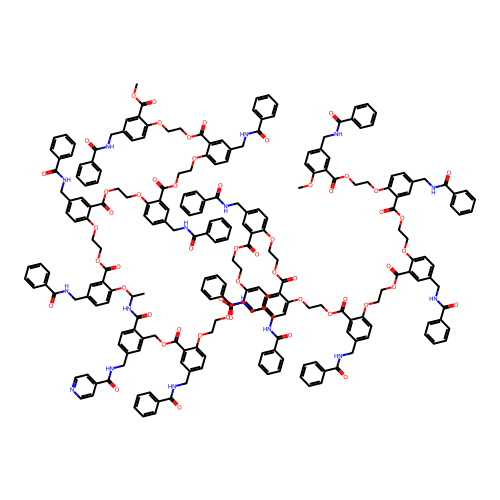

In [14]:
%%time

##plot a single example
img = plot_single_mol(list(set(valid_smiles))[1])
img.save(WRITEPATH + '/GAN_generated_img_best_tuned.png')
img

CPU times: user 4.6 s, sys: 10.2 ms, total: 4.61 s
Wall time: 4.6 s


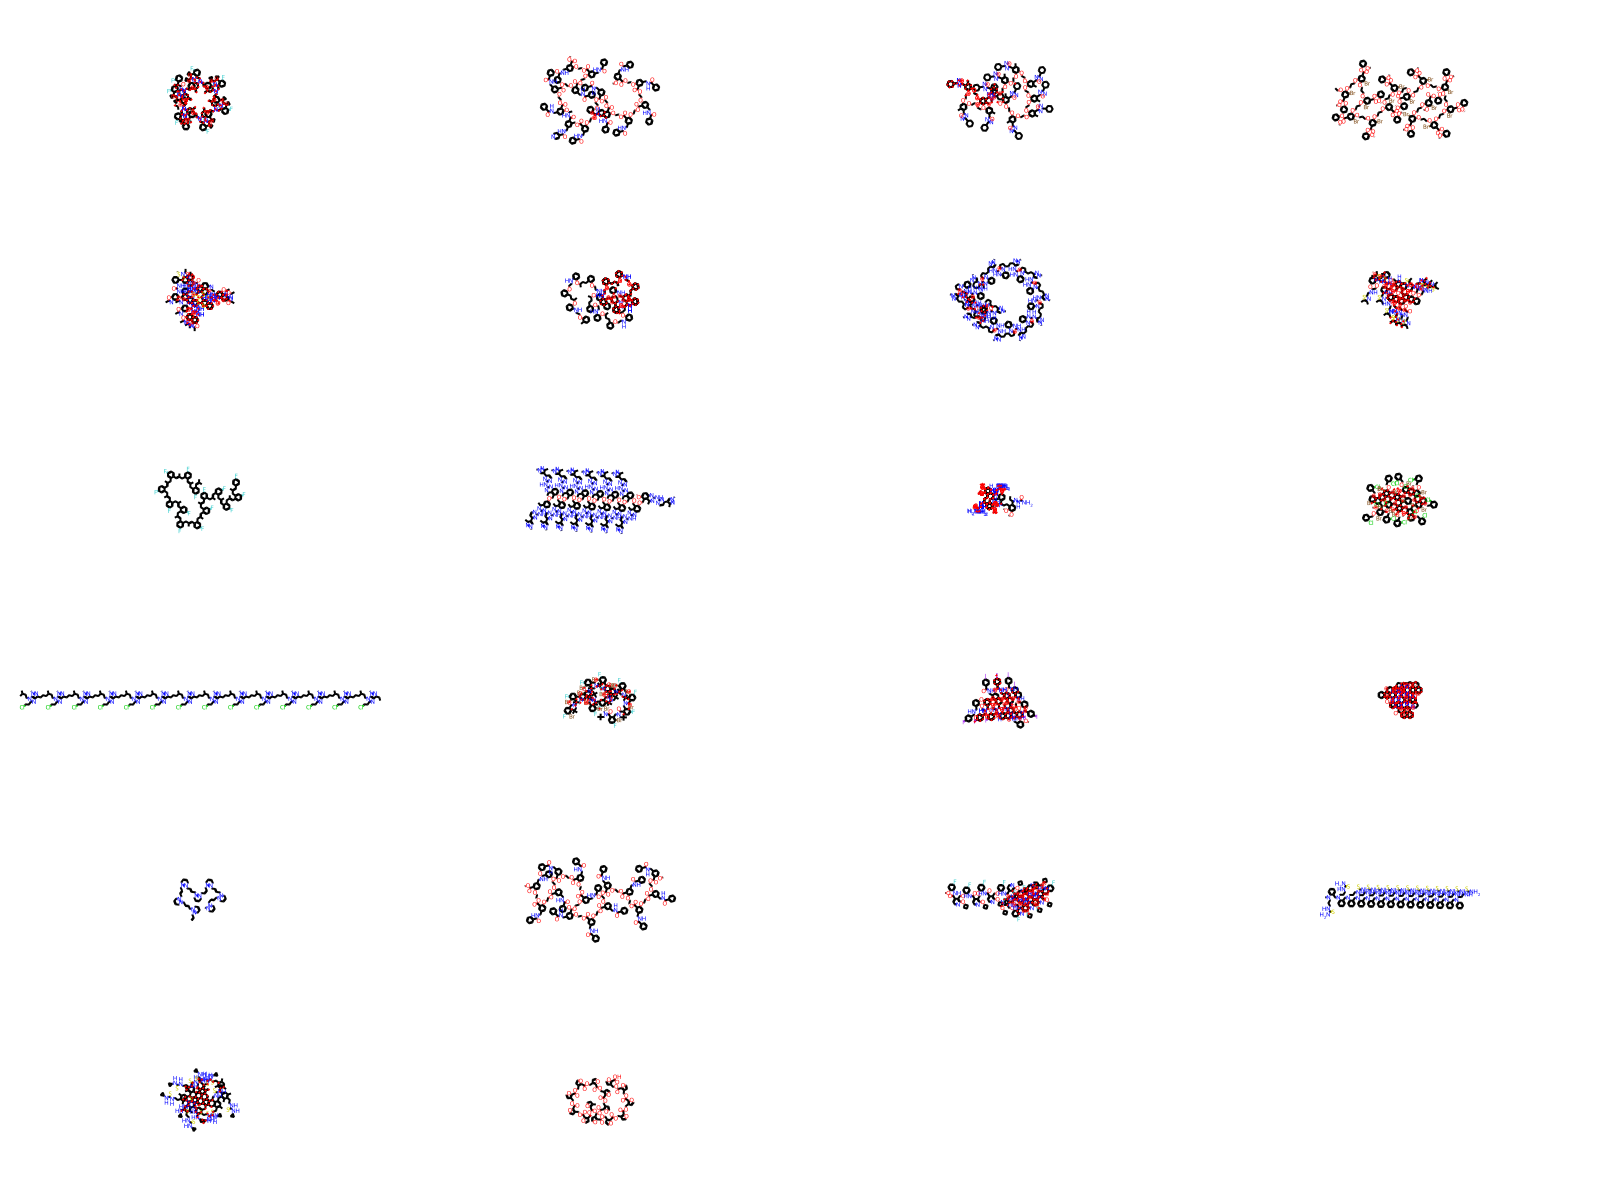

In [15]:
%%time

grid_img = plot_smiles_grid(smiles_list=list(set(valid_smiles)))
with open(WRITEPATH + "/grid_gan_generated_best_tuned.png", "wb") as f:
    f.write(grid_img.data)

grid_img

In [16]:
##clean and time
gc.collect()
torch.cuda.empty_cache()
tf = time.time()
print('Total Runtime: ', np.round(tf - t0, 3))

Total Runtime:  278.941


### REFERENCES

Alqahtani, H. E. (2019, Dec 19). Applications of Generative Adversarial Networks (GANS): An Updated Review.

Arjovsky, M. E. (2017, Jan 26). Wasserstein GAN.

Bidisha, S. (2019). NeVAE: A Deep Generative Model for Molecular Graphs.

Goodfellow, E. A. (2014, June 10). Generative Adversarial Networks.

Jaun-Ni Wu, E. A. (2024). t-SMILES: A Fragment-based Molecular Representation Framework for De Novo Ligand Design. Hunan, China.

National Library of Medicine. (2024, July 22). National Center for Biotechnology Information. Retrieved from PubChem: https://pubchem.ncbi.nlm.nih.gov/

Nicola De Cao, T. K. (2018). MolGAN: An Implicit Generative Model for Small Molecular Graphs. Stochholm, Sweden.